
# 1. 관련 라이브러리 및 데이터 로드

In [156]:
import numpy as np
import pandas as pd
import os
import math

import sklearn.tree
import sklearn.ensemble

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

path = "drive/MyDrive/AI강의과제/"
train_src = "ML-MATT-CompetitionQT2021_train.csv"
test_src = "ML-MATT-CompetitionQT2021_test.csv"

In [157]:
train = pd.read_csv(path+train_src, encoding="cp949", sep=";")
test = pd.read_csv(path+test_src, encoding="cp949", sep=";")

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36904 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36904 non-null  object 
 1   CellName     36904 non-null  object 
 2   PRBUsageUL   36904 non-null  float64
 3   PRBUsageDL   36904 non-null  float64
 4   meanThr_DL   36904 non-null  float64
 5   meanThr_UL   36904 non-null  float64
 6   maxThr_DL    36904 non-null  float64
 7   maxThr_UL    36904 non-null  float64
 8   meanUE_DL    36904 non-null  float64
 9   meanUE_UL    36904 non-null  float64
 10  maxUE_DL     36904 non-null  int64  
 11  maxUE_UL     36904 non-null  int64  
 12  maxUE_UL+DL  36904 non-null  int64  
 13  Unusual      36904 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 3.9+ MB


In [159]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         9158 non-null   object 
 1   CellName     9158 non-null   object 
 2   PRBUsageUL   9158 non-null   float64
 3   PRBUsageDL   9158 non-null   float64
 4   meanThr_DL   9158 non-null   float64
 5   meanThr_UL   9158 non-null   float64
 6   maxThr_DL    9158 non-null   float64
 7   maxThr_UL    9158 non-null   float64
 8   meanUE_DL    9158 non-null   float64
 9   meanUE_UL    9158 non-null   float64
 10  maxUE_DL     9158 non-null   int64  
 11  maxUE_UL     9158 non-null   int64  
 12  maxUE_UL+DL  9158 non-null   int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 930.2+ KB


# 2. Feature 추가(Time Related Feature), TRAIN / VALID / TEST 데이터 분류

In [160]:
X = train.drop('Unusual', axis='columns')
y = train['Unusual']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.8,
                                                                random_state=1, stratify = y)
X_test = test

In [161]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  #data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  data["TimeCos"] = data["Time"].apply(lambda x: math.cos(getTimeInMinutes(x)*math.pi/(12*60)))
  data["TimeSin"] = data["Time"].apply(lambda x: math.sin(getTimeInMinutes(x)*math.pi/(12*60)))
  del data["Time"]

  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  return data

In [162]:
#Refactoring data from features to useful values
X_train_df = refactorFeaturesDataframe(X_train)
X_train = X_train_df.to_numpy()
y_train = y_train.to_numpy()
X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()
X_test = refactorFeaturesDataframe(test).to_numpy()

#3. 선형(PCA)/비선형(TSNE) 차원축소 및 성능 테스트

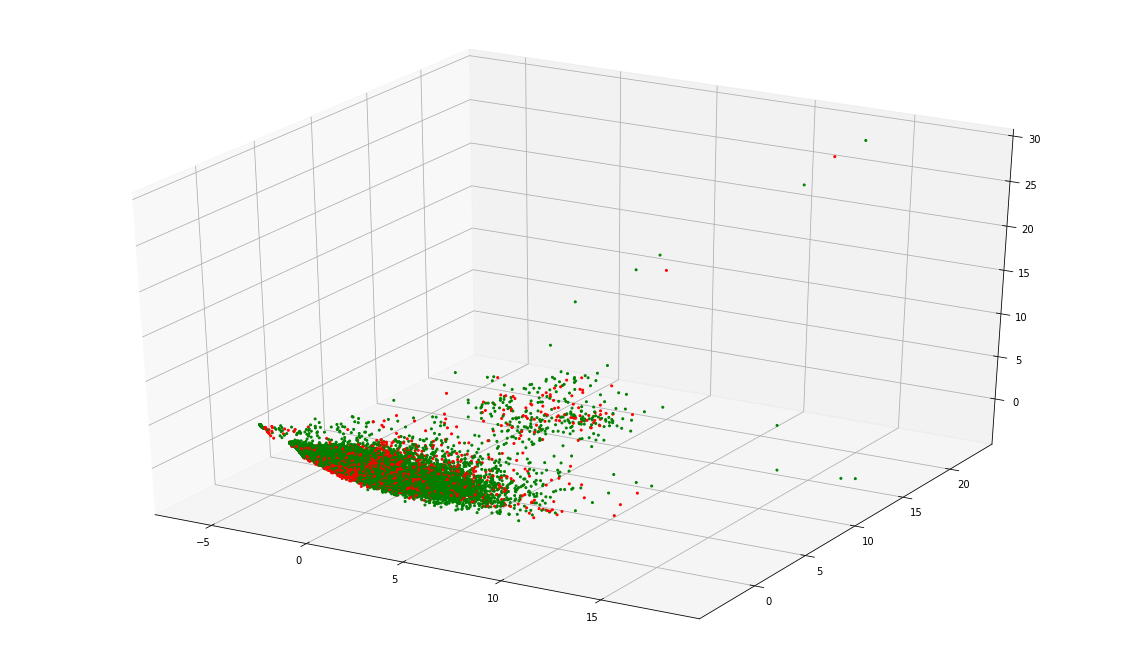

[0.43386151 0.12128982 0.08283875]


In [96]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

colors=['green' if l==0 else 'red' for l in y_train]
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=1,color=colors)
plt.show()
print(pca.explained_variance_ratio_)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 29523 samples in 0.068s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 29523 samples in 3.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29523
[t-SNE] Computed conditional probabilities for sample 2000 / 29523
[t-SNE] Computed conditional probabilities for sample 3000 / 29523
[t-SNE] Computed conditional probabilities for sample 4000 / 29523
[t-SNE] Computed conditional probabilities for sample 5000 / 29523
[t-SNE] Computed conditional probabilities for sample 6000 / 29523
[t-SNE] Computed conditional probabilities for sample 7000 / 29523
[t-SNE] Computed conditional probabilities for sample 8000 / 29523
[t-SNE] Computed conditional probabilities for sample 9000 / 29523
[t-SNE] Computed conditional probabilities for sample 10000 / 29523
[t-SNE] Computed conditional probabilities for sample 11000 / 29523
[t-SNE] Computed conditional probabilities for sample 12000 / 29523
[t-SNE] Computed conditional probabilities for sample 13000 / 29523
[t-SNE] Computed conditional probabilities for sample 14000 / 29523

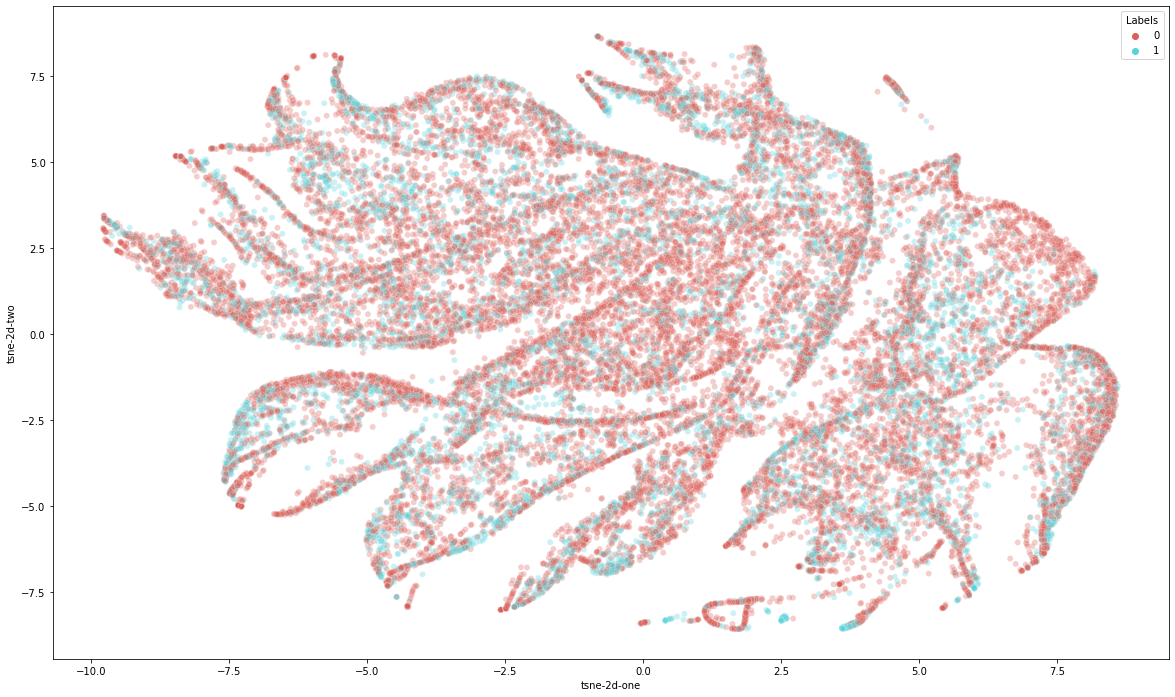

In [97]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['Labels'] = y_train

plt.figure(figsize=(20,12))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Labels",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

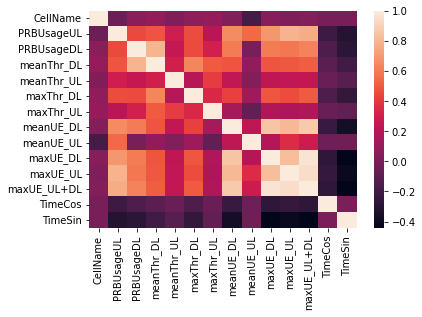

In [98]:
corrMatrix = X_train_df.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

#4. AI 기본 모델 선정

1. MLP
2. DECESION TREE - Random Forest
3. DECESION TREE - XGBoost
4. SVM - Radial Basis Function Kernel

# 4-1 Tensorflow MLP Basic Model TEST

In [122]:
import tensorflow as tf

print(X_train.shape, X_validation.shape, y_train.shape, y_validation.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [123]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))

Epoch 1/20
923/923 [==============================] - 5s 5ms/step - loss: 0.6579 - accuracy: 0.6906 - val_loss: 0.5624 - val_accuracy: 0.7273
Epoch 2/20
923/923 [==============================] - 5s 5ms/step - loss: 0.5685 - accuracy: 0.7265 - val_loss: 0.5582 - val_accuracy: 0.7292
Epoch 3/20
923/923 [==============================] - 4s 5ms/step - loss: 0.5534 - accuracy: 0.7332 - val_loss: 0.5406 - val_accuracy: 0.7387
Epoch 4/20
923/923 [==============================] - 4s 4ms/step - loss: 0.5447 - accuracy: 0.7379 - val_loss: 0.5348 - val_accuracy: 0.7388
Epoch 5/20
923/923 [==============================] - 4s 4ms/step - loss: 0.5387 - accuracy: 0.7406 - val_loss: 0.5327 - val_accuracy: 0.7395
Epoch 6/20
923/923 [==============================] - 3s 3ms/step - loss: 0.5317 - accuracy: 0.7453 - val_loss: 0.5284 - val_accuracy: 0.7420
Epoch 7/20
923/923 [==============================] - 3s 3ms/step - loss: 0.5258 - accuracy: 0.7489 - val_loss: 0.5181 - val_accuracy: 0.7541
Epoch 

# 4-2 Sklearn RandomForest Basic model TEST

In [130]:
from sklearn.ensemble import RandomForestClassifier

clf_rfc = RandomForestClassifier(n_estimators=100)
clf_rfc.fit(X_train, y_train)

from sklearn import metrics
y_pred = clf_rfc.predict(X_validation)
print("RandomForest Accuracy:",metrics.accuracy_score(y_validation, y_pred))

Accuracy: 0.946484216230863


## 4-3 Sklearn Xgboost Basic Model TEST 

In [132]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(n_estimators=100)
clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_validation)
print("XGBoost Accuracy:",metrics.accuracy_score(y_validation, y_pred))

XGBoost Accuracy: 0.9418777943368107


# 4-4 Sklearn SVM Basic Model TEST

In [133]:
from sklearn import svm

clf_svm = svm.SVC(kernel="rbf")
clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_validation)
print("SVM Accuracy:",metrics.accuracy_score(y_validation, y_pred))

SVM Accuracy: 0.7240211353475139


# 5. XGBoost Model Parameter Tunning ( RandomizedSearchCV / GridSearchCV ...)
* RandomizedSearchCV: 제한된 범위 내 파라미터 중 랜덤하게 n_iter 파라미터 설정을 통해, 순환 횟수를 설정할 수 있음
* GridSearchCV: 파라미터 제한을 범위 및 step까지 설정 후, 모든 파라미터에 대해 전체순환, 성능은 더 좋을 수 있으나 파라미터 수와 범위가 많아질수록 순환횟수 또한 기하급수적으로 커짐

In [146]:
from xgboost import XGBClassifier, plot_importance
from google.colab import files
from scipy.stats import uniform, randint
from sklearn.metrics import accuracy_score, f1_score

pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                     ('xgb_clf', XGBClassifier(random_state=1))])

parameters = {
'xgb_clf__eta'    : uniform(0.2, 0.35),
"xgb_clf__colsample_bytree": uniform(0.05, 0.2),
"xgb_clf__min_child_weight": randint(1, 5),
"xgb_clf__gamma": uniform(0.35, 0.6),
"xgb_clf__learning_rate": uniform(0.1, 0.3), # default 0.1 
"xgb_clf__max_depth": randint(10, 30), # default 3
"xgb_clf__n_estimators": randint(500, 1000), # default 100
"xgb_clf__subsample": uniform(0.6, 0.99)
}

clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=5, n_iter= 500)

clf_GS.fit(X_train, y_train)

print('최적 하이퍼파라미터: ', clf_GS.best_params_)
y_pred = clf_GS.predict(X_validation)
print('검증 정확도:', clf_GS.best_score_)
print('F1:',f1_score(y_validation, y_pred))

최적 하이퍼파라미터:  {'xgb_clf__colsample_bytree': 0.11944702904112472, 'xgb_clf__eta': 0.41896888868896076, 'xgb_clf__gamma': 0.9391698405761839, 'xgb_clf__learning_rate': 0.26577202031645947, 'xgb_clf__max_depth': 12, 'xgb_clf__min_child_weight': 1, 'xgb_clf__n_estimators': 774, 'xgb_clf__subsample': 0.9382250209735967}
검증 정확도: 0.9929886022822971
F1: 0.9860627177700347


In [163]:
from xgboost import XGBClassifier, plot_importance
from joblib import dump, load
from google.colab import files
from scipy.stats import uniform, randint

try:
  clf_GS = load(path + 'xgb_model.joblib') 
  training = False
  
except:
  training = True
  pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                         ('xgb_clf', XGBClassifier(random_state=1,
                                                      scale_pos_weight=7,
                                                      colsample_bytree= 0.053381469489678104,
                                                      eta= 0.20289460663803338,
                                                      gamma= 0.88723107873764,
                                                      learning_rate= 0.15455380920536027,
                                                      max_depth= 26,
                                                      min_child_weight= 1,
                                                      n_estimators= 565,
                                                      subsample= 0.9738168894035317))])
   parameters = {
  # 'xgb_clf__eta'    : uniform(0.2, 0.35),
  # "xgb_clf__colsample_bytree": uniform(0.05, 0.2),
  # "xgb_clf__min_child_weight": randint(1, 5),
  # "xgb_clf__gamma": uniform(0.35, 0.6),
  # "xgb_clf__learning_rate": uniform(0.1, 0.3), # default 0.1 
  # "xgb_clf__max_depth": randint(10, 30), # default 3
  # "xgb_clf__n_estimators": randint(500, 1000), # default 100
  # "xgb_clf__subsample": uniform(0.6, 0.99)
  }
  
  clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
  clf_GS.fit(X_train, y_train)    

Fitting 1 folds for each of 1 candidates, totalling 1 fits


# 6. SelectFromModel API를 활용한 이전 모델 Feature Imporance 활용

In [166]:
from sklearn.feature_selection import SelectFromModel

if training:

  treshold_train_error = []
  treshold_val_error = []
  thresholds = np.sort(clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_)
  
  current_error = 100.0
  best_th = 0

  for thresh in thresholds:

    # Do a feature reduction with relevant feature
    new_X_train = X_train
    selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=thresh, prefit=True)
    select_X_train = selection.transform(new_X_train)
      
    # Fit the classifier with the reduced dataset
    selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
    selection_model.fit(select_X_train, y_train)
    
    # Evaluate predictions with the dataset trained with the feature reduction
    pred_train = selection_model.predict(select_X_train)
    select_X_val = selection.transform(X_validation)
    pred_val = selection_model.predict(select_X_val)
    

    """"                       
         Classification report
         ---------------------
    """
    train_error = 1. - accuracy_score(y_train, pred_train)    
    train_cmat = confusion_matrix(y_train, pred_train)
    val_error = 1. - accuracy_score(y_validation, pred_val)
    val_cmat = confusion_matrix(y_validation, pred_val)

    treshold_train_error.append(train_error)
    treshold_val_error.append(val_error)

    print("\nThreshold of value %f" % thresh)
    print("--------------------------------")
    print('\ntrain error: %f ' % train_error)
    print('train confusion matrix:')
    print(train_cmat)
    print('\ntest error: %f ' % val_error)
    print('test confusion matrix:')
    print(val_cmat)
    print("\n")

    if val_error < current_error:
      current_error = val_error
      best_th = thresh
      best_transformation = select_X_train

Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.006863
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.004335 
test confusion matrix:
[[5341    3]
 [  29 2008]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.007244
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.004606 
test confusion matrix:
[[5341    3]
 [  31 2006]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.010437
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.003794 
test confusion matrix:
[[5342    2]
 [  26 2011]]


Fitting 1 folds for each of 1 candidates, totalling 1 fits

Threshold of value 0.012320
--------------------------------

train error: 0.000000 
train confusion matrix:
[[2137

#7. BEST Model 저장 및 모델평가

In [167]:
  from sklearn.feature_selection import SelectFromModel

  # Get the best estimator we found in the previous block
  new_X_train = X_train
  selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=best_th , prefit=True)
  select_X_train = selection.transform(new_X_train)

  # Train the classifier with the best feature reduction
  selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=[(slice(None), slice(None))], n_iter= 1)
  selection_model.fit(select_X_train, y_train)

  # Save the model in a file and download locally.
  dump(clf_GS, path + 'xgb_model.joblib')
  files.download(path + 'xgb_model.joblib')

  pred_train = selection_model.predict(select_X_train)
  select_X_val = selection.transform(X_validation)
  pred_val = selection_model.predict(select_X_val)

  train_error = 1. - accuracy_score(y_train, pred_train)
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  
  """"                       
         Classification report
         ---------------------
  """

  print("\nThreshold of value %f" % thresh)
  print("--------------------------------")
  print('\ntrain error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('\ntest error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)
  print("\n")

  print("TRAINING\n" + classification_report(y_train, pred_train))
  print("\nTESTING\n" + classification_report(y_validation, pred_val))

Fitting 1 folds for each of 1 candidates, totalling 1 fits


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Threshold of value 0.303718
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002439 
test confusion matrix:
[[5340    4]
 [  14 2023]]


TRAINING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21377
           1       1.00      1.00      1.00      8146

    accuracy                           1.00     29523
   macro avg       1.00      1.00      1.00     29523
weighted avg       1.00      1.00      1.00     29523


TESTING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5344
           1       1.00      0.99      1.00      2037

    accuracy                           1.00      7381
   macro avg       1.00      1.00      1.00      7381
weighted avg       1.00      1.00      1.00      7381



# 8. 모델 평가

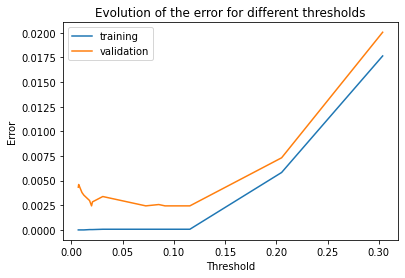

In [168]:
  fig, ax = plt.subplots()
  ax.plot(thresholds, treshold_train_error, label='training')
  ax.plot(thresholds, treshold_val_error, label='validation')
  ax.set(xlabel='Threshold', ylabel='Error')
  ax.legend()
  plt.title('Evolution of the error for different thresholds')
  plt.show()

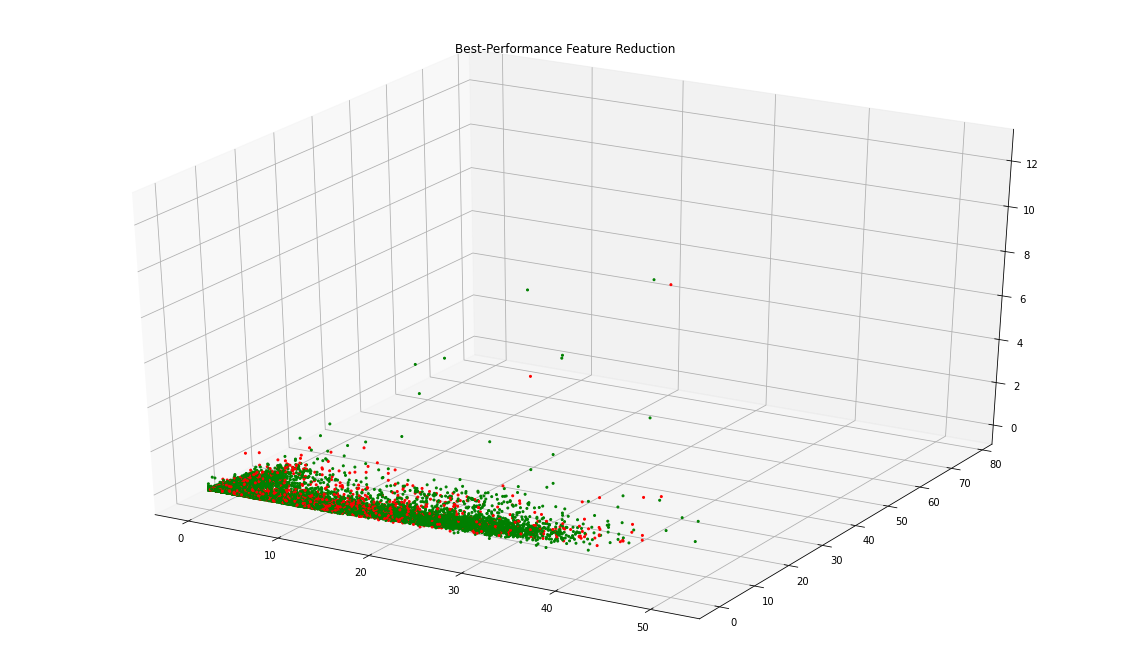

In [172]:
  colors=['green' if l==0 else 'red' for l in y_train]
  fig = plt.figure(figsize=(20,12))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(best_transformation[:,0], best_transformation[:, 1], best_transformation[:, 2], s=4, alpha=1,color=colors)

  plt.title('Best-Performance Feature Reduction')
  plt.show()

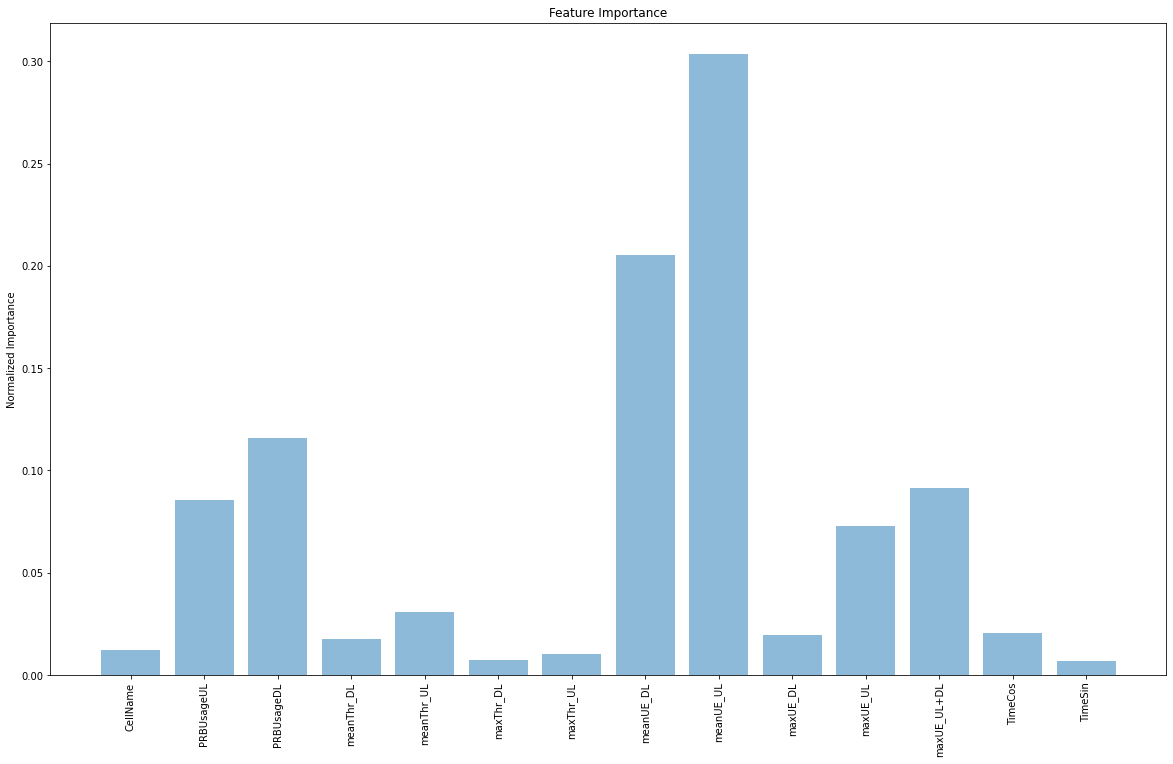

In [173]:
  feature_importances = clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_
  columns = X_train_df.columns
  
  fig = plt.figure(figsize=(20,12)) 
  plt.bar(np.arange(14) , feature_importances, align='center', alpha=0.5)
  plt.xticks(np.arange(14), columns, rotation='vertical')
  plt.ylabel('Normalized Importance')
  plt.title('Feature Importance')
  plt.show()

In [174]:
  select_X_test = selection.transform(X_test)
  pred_test = selection_model.predict(select_X_test)

In [175]:
if training == False:

  pred_train = clf_GS.predict(X_train)
  pred_val = clf_GS.predict(X_validation)

  print("TRAINING\n" + classification_report(y_train, pred_train))
  print("\nTESTING\n" + classification_report(y_validation, pred_val))

  train_error = 1. - accuracy_score(y_train, pred_train)
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  print('train error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('test error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)

In [176]:
# Create index column in data frame object
submission_dataframe = pd.DataFrame(np.arange(1, 9159), columns=['Id']) 

# Append predictions of test data as column
submission_dataframe['Label'] = pred_test

# Convert Data Frame object to CSV
submission_dataframe.to_csv(path + 'predictions.csv', index=False)

!mv predictions.csv anomaly-4G-detection/
predictions = pd.read_csv(path + 'predictions.csv')
predictions

mv: cannot stat 'predictions.csv': No such file or directory


,Id,Label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
9153,9154,0
9154,9155,1
9155,9156,0
9156,9157,0
